# Recidivism in Georgia

The dataset used is from the american National Institute of Justice describing recidivism in the state of Georgia.[1](https://nij.ojp.gov/funding/recidivism-forecasting-challenge#19-0) The data is collected for offenders released to parole for supervision in the period 2013-2015 with recidivism information about the offenders; whether or not the offender reoffends. Where we initially choose the following as interesting attributes, e.g. omitting arrest data since we find conviction data more eligible. We mark the <span style="color:green">protected features marked in green</span> and <span style="color:red">target marked in red</span>.


We are especially interested in a model predicting recidivism. In our ethical reflections we consider two cases, the predicted risk of recidivating can be used for positive and negative effects for the offender. <br>
- **Negative:**  length of sentence and opportunity for probation. 
- **Positive:** allocation of more ressources to resociale the offender e.g. educational or employment programmes. 

In either case it is not legal to discriminate in regards to protected attributes (i.e. sex and race in this case). However we would argue that being discriminating in regards to length of sentence and opportunity for probation is more significant than being discriminating in regards to ressources when released from prison. It is also possible to view it as the first is affecting your negative liberty whereas the second affects your positive liberty. [2](https://plato.stanford.edu/entries/liberty-positive-negative/)



| # | Variable | Definition |
|---|----------|------------|
| 1 | <span style="color:green">Sex</span>  | Binary: Male/Female |
| 2 | <span style="color:green">Race</span> | Binary: Black/White* |
| 3 | Age_at_Release | Categorical: 18-22, 23-27, 28-32, 33-37, 38-42, 43-47, 48+ |
| 4 | Gang_Affiliated | Binary: True/False, verified by investigation |
| 5 | Supervision_Risk_Score_First | Scale: First Parole Supervision Risk Assessment Score (1-10, where 1=lowest risk) |
| 6 | Supervision_Level_First | Categorical: First Parole Supervision Level Assignment (Standard, High, Specialized) |
| 7 | Education_Level | Categorical: Less than High School, High School diploma, at least some college |
| 8 | Dependents | Scale: 0, 1, 2, 3+ dependents at prison entry |
| 9 | Prison_Offense | Categorical: Violent/Sex, Violent/Non-Sex, Property, Drug, Other |
| 10 | Prison_Years | Scale: <1, 1-2, 2-3, 3+. Prior to parole release. |
| 11 | Prior_Conviction_Episodes_Felony | Scale: 0, 1, 2, 3+ |
| 12 | Prior_Conviction_Episodes_Misd | Scale: 0, 1, 2, 3, 4+. Misdemeanor |
| 13 | Prior_Conviction_Episodes_Viol | Binary: True/False. Violent |
| 14 | Prior_Conviction_Episodes_Prop | Scale: 0, 1, 2, 3+. Property |
| 15 | Prior_Conviction_Episodes_Drug | Scale: 0, 1, 2+ |
| 16 | Prior_Conviction_Episodes_PPViolenceCharges | Binary: True/False. Probation/Parole violation |
| 17 | Prior_Conviction_Episodes_DomesticViolenceCharges | Binary: True/False |
| 18 | Prior_Conviction_Episodes_GunCharges | Binary: True/False |
| 19 | Condition_MH_SA | Binary: True/False. Parole Release Condition = Mental Health or Substance Abuse Programming |
| 20 | Condition_Cog_Ed | Binary: True/False. Parole Release Condition = Cognitive Skills or Education Programming |
| 21 | Condition_Other | Binary: True/False. Parole Release Condition = No Victim Contact or Electronic Monitoring or Restitution or Sex Offender Registration/Program |
| 22 | Violations_ElectronicMonitoring | Binary: True/False. |
| 23 | Violations_Instruction | Binary: True/False. Not following instructions. (Vague?) |
| 24 | Violations_FailToReport | Binary: True/False. Failure to report. (vague?) |
| 25 | Violations_MoveWithoutPermission | Binary: True/False. Moving without permission. |
| 26 | Delinquency_Reports | Scale: 0, 1, 2, 3, 4+. Number of rulebreaking during parole. |
| 27 | Program_Attendances | Scale: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10+. |
| 28 | Residence_Changes | Scale: 0, 1, 2, 3+. |
| 29 | Avg_Days_per_DrugTest | Scale: twice a day to three years |
| 30 | Drug_Tests_Positive | Binary: True/False. Substances THC, Cocaine, Meth, Other |
| 31 | Percent_Days_Employed | Scale: 0-100% |
| 32 | Jobs_Per_Year | Scale: 0, 1, 2, 3, 4, 5, 6, 7, 8 |
| 33 | Employment_Exempt | Binary: True/False |
| 34 | <span style="color:red">Recidivism</span> | Binary: True/False. Reoffend within 3 years |





\* *The data only contains individuals with the racial categories of Black and White to reduce the possibility of deductive disclosure of individuals identities. There were less than 500 individuals who were identified as Hispanic, and less than 100 individuals in each of the following categories Asian, Native American, other, and unknown; these cases were dropped from the sample to prevent inadvertent disclosure of personal Identifying information.*

We choose to group all the data for positive drug test.


Note: In the original dataset there is also a PUMA residence attribute, which could be interesting combine with supplemental data for e.g. affordability index, health or access/public transportation data.

## Thoughts for modelling

Potential modelling cases

- Classification for recidivism prediction
- Regression for supervision risk score

Methods
- Cleaning and investigating data. Avoiding data leakage
- Balance model complexity with size of data
- Trying a range of different models (Decision tree, regression, PCA and maybe SVM) using a validation set then choosing one model and finaly evaluating on a test set. 
- Evaluating accuracy and fairness metrics 


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from dython.nominal import associations
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
# Loading the dataset
df = pd.read_csv('exam_data/NIJ_s_Recidivism_Challenge_Full_Dataset.csv')

# Target is whether or not they reoffend
target=df['Recidivism_Within_3years']

# Protected features
grouprace=df['Race']
groupsex=df['Gender']

# First split: train+validation and test
X_temp, X_test, y_temp, y_test, grouprace_temp, grouprace_test, groupsex_temp, groupsex_test = train_test_split(
    df, target, grouprace, groupsex, test_size=0.2, random_state=22)

# Second split: training and validation
X_train, X_val, y_train, y_val, grouprace_train, grouprace_val, groupsex_train, groupsex_val = train_test_split(
    X_temp, y_temp, grouprace_temp, groupsex_temp, test_size=0.25, random_state=22)  # 0.25 x 0.8 = 0.2 

## Demographic of offenders

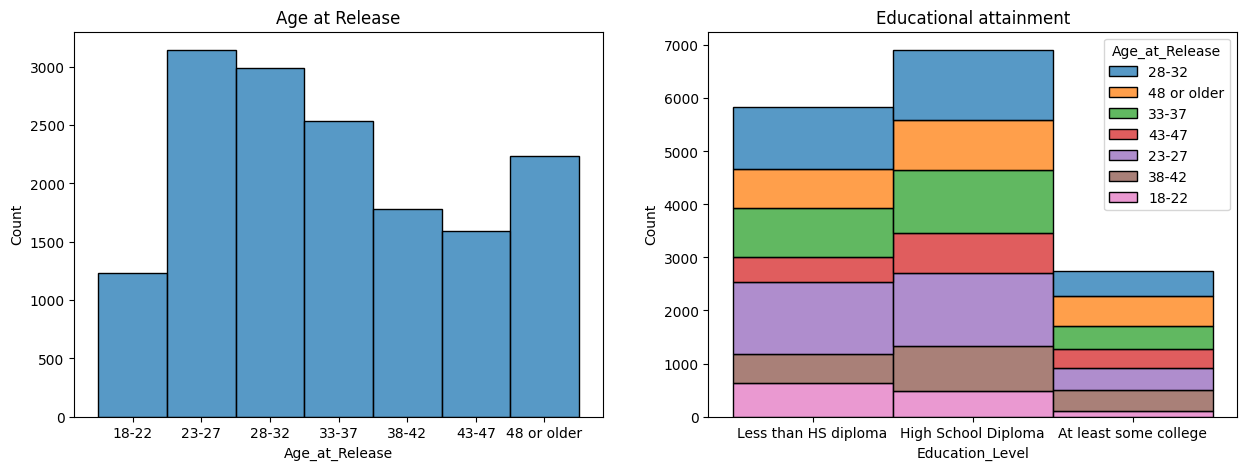

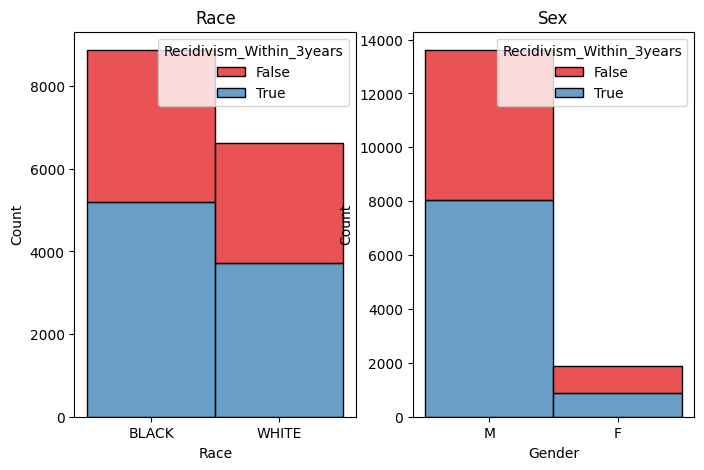

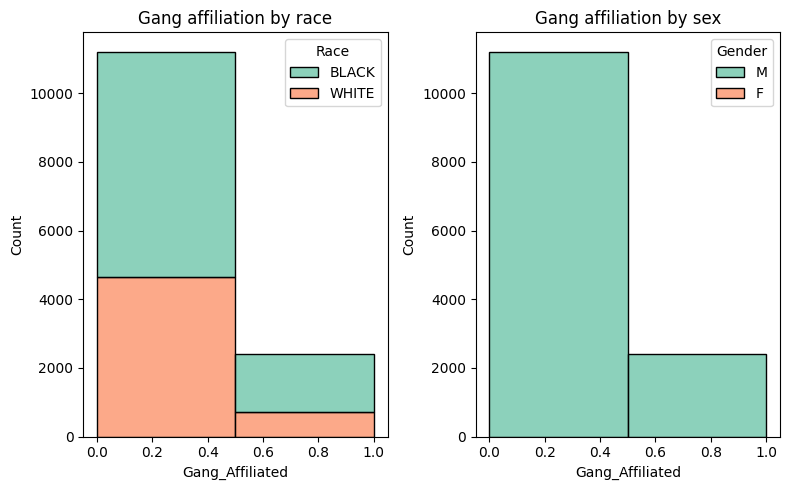

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

sns.histplot(X_train['Age_at_Release'].sort_values(), bins=5, ax=axes[0])
axes[0].set_title('Age at Release')

X_train['Education_Level'] = pd.Categorical(X_train['Education_Level'], ['Less than HS diploma', 'High School Diploma', 'At least some college'])
sns.histplot(data=X_train, x='Education_Level', bins=3, ax=axes[1], hue='Age_at_Release', multiple='stack')
axes[1].set_title('Educational attainment')


fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # Recidivism

sns.histplot(x='Race', data=X_train, ax=axes[0], bins=2, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[0].set_title('Race')

sns.histplot(x='Gender', data=X_train, ax=axes[1], bins=2, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[1].set_title('Sex')

fig, axes = plt.subplots(1, 2, figsize=(8, 5))  # 1 row, 2 columns

sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[0], bins=2, palette='Set2', hue='Race', multiple='stack')
axes[0].set_title('Gang affiliation by race')


sns.histplot(x='Gang_Affiliated', data=X_train, ax=axes[1], bins=2, palette='Set2', hue='Gender', multiple='stack')
axes[1].set_title('Gang affiliation by sex')
# The Gang affiliation values for females are NaN!

plt.tight_layout()

In [5]:
# Chekcing for missing female gang affiliation values
print(X_train.groupby(['Gender', 'Gang_Affiliated']).size())
print(X_train.groupby(['Gender']).size())

Gender  Gang_Affiliated
M       False              11216
        True                2396
dtype: int64
Gender
F     1889
M    13612
dtype: int64


## Risk score and recidivism

We are provided with a risk score, it could be interesting to investigate if there is a bias or if it's reasonably correlated with recidivism (or how violent the crime is). We see a potential for the risk score to be biased.

Text(0.5, 1.0, 'Risk score and type of offense')

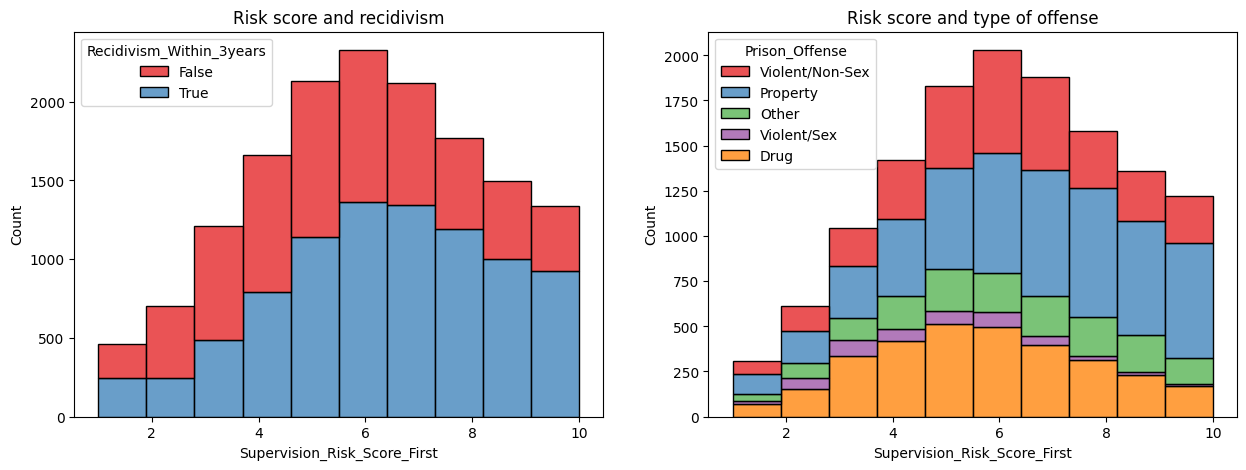

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Recidivism

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[0], bins=10, palette='Set1', hue='Recidivism_Within_3years', multiple='stack')
axes[0].set_title('Risk score and recidivism')

sns.histplot(x='Supervision_Risk_Score_First', data=X_train, ax=axes[1], bins=10, palette='Set1', hue='Prison_Offense', multiple='stack')
axes[1].set_title('Risk score and type of offense')


### A quick view on the drug data (avg days between test and age)

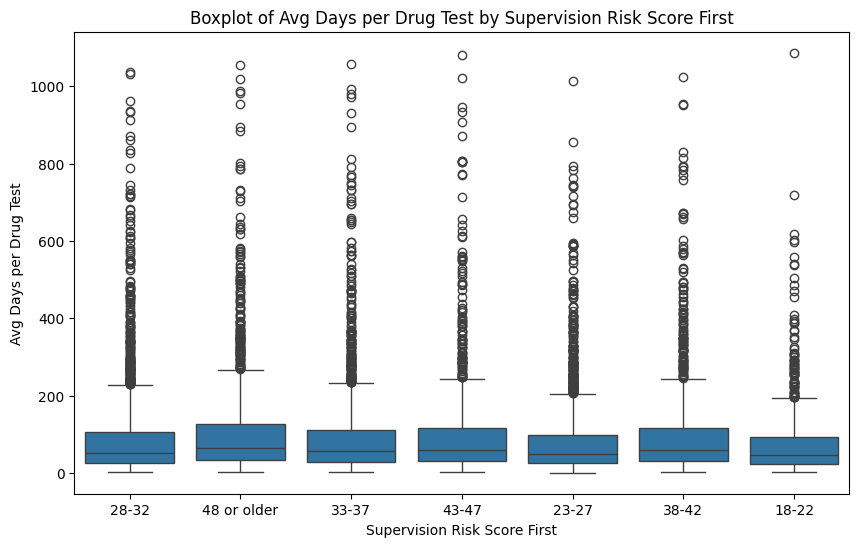

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_at_Release', y='Avg_Days_per_DrugTest', data=X_train)

plt.xlabel('Supervision Risk Score First')
plt.ylabel('Avg Days per Drug Test')
plt.title('Boxplot of Avg Days per Drug Test by Supervision Risk Score First')

# Show the plot
plt.show()

## Preprocessing
### Dropping and grouping columns

In [8]:
# Grouping drug data
df['DrugTest_Positive']=df[['DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive']].any(axis=1)


# Changing age categories to numerical data
df['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
df['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
df['Education_Level']=df['Education_Level'].replace(['Less than HS diploma','High School Diploma', 'At least some college'], [1,2,3])
df['Prison_Years']=df['Prison_Years'].replace(['Less than 1 year','1-2 years','Greater than 2 to 3 years','More than 3 years'],[1,2,3,4])
df['Race']=df['Race'].replace(['WHITE','BLACK'],[1,0])
df['Sex']=df['Gender'].replace(['M','F'],[1,0])

  
# Handling NaN values
df['Gang_Affiliated']=df['Gang_Affiliated'].fillna(0).astype(int)
df['Supervision_Risk_Score_First']=df['Supervision_Risk_Score_First'].fillna(0).astype(int)
df['Supervision_Level_First']=df['Supervision_Level_First'].fillna(0).astype(int)
df['Avg_Days_per_DrugTest']=df['Avg_Days_per_DrugTest'].fillna(10000).astype(int) # Filling with a large value to indicate the drug test would be rarely
df['Percent_Days_Employed']=df['Percent_Days_Employed'].fillna(df['Percent_Days_Employed'].mean()).astype(int)
df['Jobs_Per_Year']=df['Jobs_Per_Year'].fillna(df['Jobs_Per_Year'].mean()).astype(int)


# Dropping columns
df=df.drop(['Gender','ID','Residence_PUMA','Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges','Program_UnexcusedAbsences','Prior_Revocations_Parole',
       'Prior_Revocations_Probation','DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive','Recidivism_Arrest_Year1',
       'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3', 'Training_Sample', 'Recidivism_Within_3years'], axis=1)

def extract_number(val):
    import re
    val_str = str(val)
    match = re.search(r'\d+', val_str)
    return int(match.group()) if match else pd.NA

cols = ['Dependents', 'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug','Delinquency_Reports', 'Program_Attendances', 'Residence_Changes']
df[cols] = df[cols].applymap(extract_number).astype('Int64')

# One hot encoding prison offence
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=['Prison_Offense'], drop_first=True)

# Specify the columns you want first
first_columns = ['Sex', 'Race']

# Get the remaining columns
remaining_columns = [col for col in df.columns if col not in first_columns]

# Rearrange the DataFrame
df = df[first_columns + remaining_columns]

X_train, X_test, y_train, y_test, grouprace_train, grouprace_test, groupsex_train, groupsex_test = train_test_split(
    df, target, grouprace, groupsex, test_size=0.2, random_state=22)

X_train=X_train.astype(float)

# Standardizing all features
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test[X_train.columns])

C:\Users\Bruger\AppData\Local\Temp\ipykernel_9152\2495529987.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Age_at_Release']=df['Age_at_Release'].replace(['18-22','23-27','28-32','33-37','38-42', '43-47','48 or older'], [1,2,3,4,5,6,7])
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9152\2495529987.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Supervision_Level_First']=df['Supervision_Level_First'].replace(['Standard', 'High', 'Specialized'], [1,2,3])
C:\Users\Bruger\AppData\Local\Temp\ipykernel_9152\2495529987.py

## Correlations

In [ ]:
# Categorical columns 
categorical_columns = ['Gender', 'Race', 'Gang_Affiliated', 'Prison_Offense', 'Education_Level','Condition_MH_SA', 'Condition_Cog_Ed', 'Condition_Other', 
                   'Violations_ElectronicMonitoring', 'Violations_Instruction', 
                   'Violations_FailToReport', 'Violations_MoveWithoutPermission', 
                   'Employment_Exempt', 'DrugTest_Positive']


# Numerical columns 
numerical_columns = ['Age_at_Release', 'Supervision_Risk_Score_First', 'Supervision_Level_First',
                     'Dependents', 'Prison_Years', 'Prior_Conviction_Episodes_Felony',
                     'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Viol', 
                     'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 
                     'Prior_Conviction_Episodes_PPViolationCharges', 
                     'Prior_Conviction_Episodes_DomesticViolenceCharges',
                     'Prior_Conviction_Episodes_GunCharges', 'Delinquency_Reports', 
                     'Program_Attendances', 'Residence_Changes', 'Avg_Days_per_DrugTest', 
                     'Percent_Days_Employed', 'Jobs_Per_Year']

# Compute associations
results = associations(
    Xs_train,
    nominal_columns=categorical_columns,  
    numerical_columns=numerical_columns,  
    nom_nom_assoc='cramer',  # Cramer's V for categorical-categorical
    num_num_assoc='pearson',  # Pearson's correlation for numeric-numeric
    nom_num_assoc='correlation_ratio',  # correlation ratio for mixed columns?
    plot=False
)

corr_pear_cramer = results['corr']
corr_pear_cramer.columns = X_train.columns

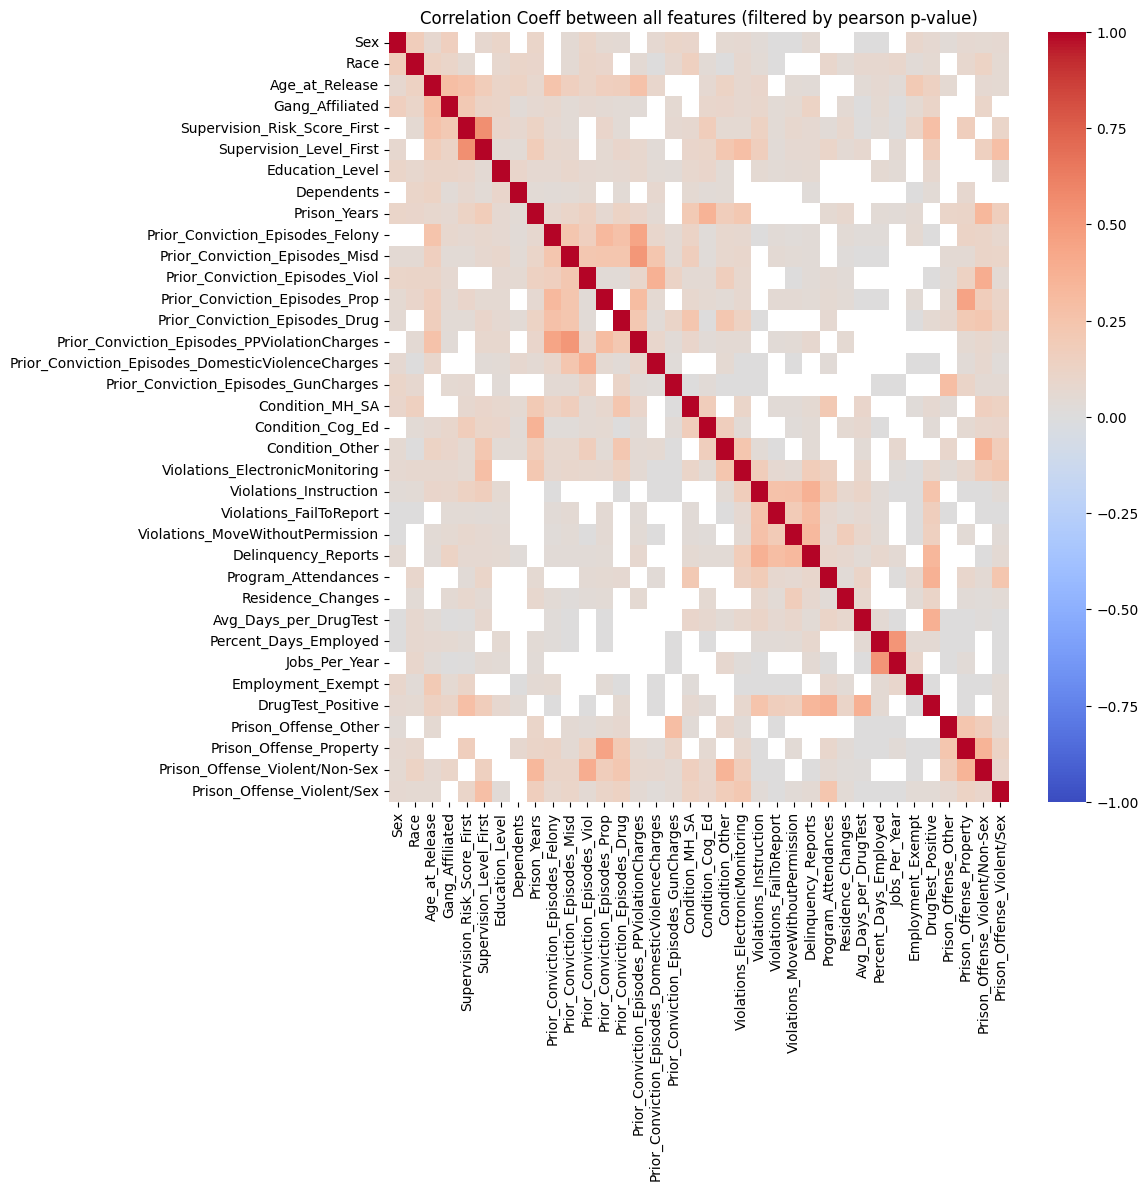

In [ ]:
n_features = X_train.shape[1]
alpha = 0.05 # Significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

# Compute p-value using pearson
corr_pearson = np.zeros((n_features, n_features))
p = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_pearson[i,j], p[i,j] = pearsonr(Xs_train[:,i], Xs_train[:,j])
        if np.isnan(corr_pearson[i,j]):
            p[i,j] = 1

# Maybe a better mask can be found for cramer?

plt.figure(figsize=(10,10))
sns.heatmap(corr_pear_cramer, vmin=-1, vmax=1, cmap="coolwarm", xticklabels=corr_pear_cramer.columns, yticklabels=X_train.columns, mask= (p > corrected_alpha)  & (corr_pear_cramer > 0.005)) ## mask if p is higher
plt.title("Correlation Coeff between all features (filtered by pearson p-value)")
plt.show()

# Dython association gives only 0 to 1 association

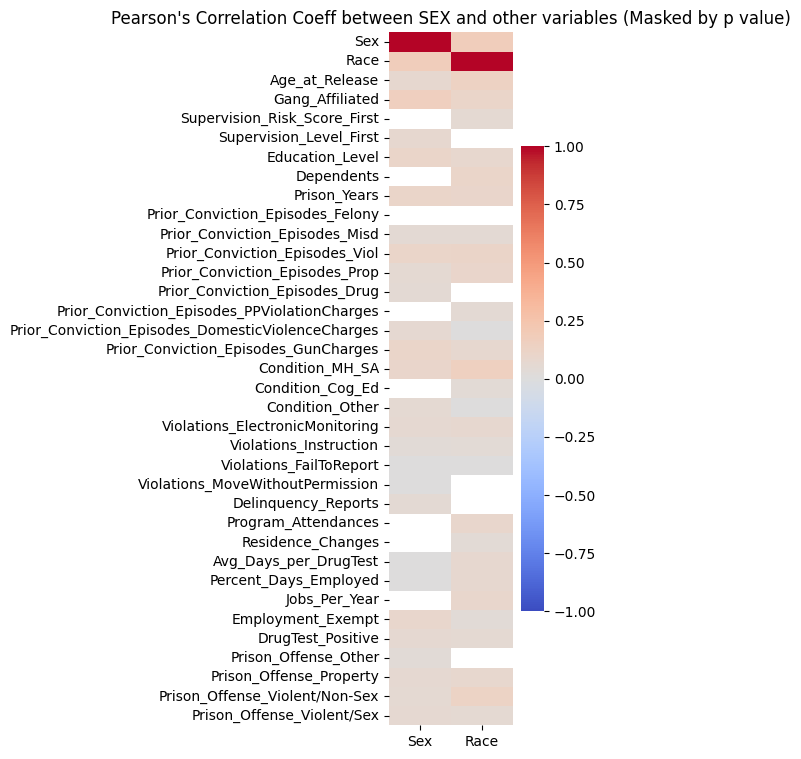

In [ ]:
plt.figure(figsize=(2,9))
sns.heatmap(corr_pear_cramer[['Sex','Race']], cmap="coolwarm", xticklabels=['Sex','Race'], yticklabels=X_train.columns,  mask = ((p > corrected_alpha)  & (corr_pear_cramer > 0.005))[['Sex','Race']], vmin=-1, vmax=1)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

## First model fittings

In [ ]:
# Saving a training dataset without the protected features
Xs_train_none = np.delete(Xs_train, [0,1], axis=1)
Xs_test_none = np.delete(Xs_test, [0,1], axis=1)

In [ ]:
group_test_dict = {
    'Male': groupsex_test == 'M',
    'Female': groupsex_test == 'F',
    'White': grouprace_test == 'WHITE',
    'Black':  grouprace_test == 'BLACK'
}

# Fit LR model
model = LogisticRegression(penalty=None, max_iter=1000)
model.fit(Xs_train_none, y_train)
y_hatLR = model.predict(Xs_test_none.astype(float))

# Fit RF model
clf = RandomForestClassifier(max_depth=5, 
                             random_state=33, 
                             n_jobs=-1, 
                             n_estimators=30) 

clf.fit(Xs_train_none, y_train)
y_hatRF = clf.predict(Xs_test_none.astype(float))

print('Logistic regression model')
# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hatLR[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hatLR[group_idxs]):.2f}')


print('\nRandom forest model')
# Calculate and print F1 Scores for each group
for group, group_idxs in group_test_dict.items():
    print(f'F1, {group}: {f1_score(y_test[group_idxs], y_hatRF[group_idxs]):.2f}')

# Calculate and print positive rates for each group
for group, group_idxs in group_test_dict.items():
    print(f'Positive Rate, {group}: {np.mean(y_hatRF[group_idxs]):.2f}')

Logistic regression model
F1, Male: 0.76
F1, Female: 0.66
F1, White: 0.75
F1, Black: 0.75
Positive Rate, Male: 0.68
Positive Rate, Female: 0.56
Positive Rate, White: 0.64
Positive Rate, Black: 0.68

Random forest model
F1, Male: 0.77
F1, Female: 0.65
F1, White: 0.76
F1, Black: 0.76
Positive Rate, Male: 0.78
Positive Rate, Female: 0.71
Positive Rate, White: 0.76
Positive Rate, Black: 0.79
